### Эвристика для поиска ROI

Вместо того, чтобы применять классификатор "наобум", можно для начала выбрать те области изображения, в которых вероятность нахождения объекта наиболее высока и запускать классификатор лишь для них.

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/heuristics_way_object_detection_multiple_object.png" width="700">

<center><p><em>Source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf">Detection and Segmentation</a></p> </em></center>

Такие области называются **regions of interest**, сокращённо — **ROI**. 

Для поиска таких областей можно использовать какой-либо эвристический алгоритм, например [Selective search](https://ivi.fnwi.uva.nl/isis/publications/bibtexbrowser.php?key=UijlingsIJCV2013&bib=all.bib).

#### Selective search

Selective search — известный алгоритмический метод поиска **ROI**.

Идея алгоритма состоит в разбиении изображения на небольшие области и последующем их итеративном объединении.

Объединение происходит на основании сходства, которое вычисляется как сумма 4-х метрик (см. иллюстрацию)

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/selective_search.png" width="800">

<center><p><em>Source: <a href="http://www.huppelen.nl/publications/selectiveSearchDraft.pdf"> Selective Search for Object Recognition </a></p></em></center>


Возвращает порядка 2000 прямоугольников для изображения, отрабатывает за несколько секунд на CPU.

### R-CNN (Region CNN)



Первая известная модель, построенная по описанному принципу:

- на изображении ищутся ROI,
- для каждого делается resize,
- каждый ROI обрабатывается сверточной сетью, которая предсказывает класс объекта, который в него попал.

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/region_of_interest_cnn.png" width="700">

<center><p><em>Source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf">Detection and Segmentation</a></p> </em></center>

Кроме класса модель предсказывает смещения для каждого bounding box

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/r_cnn_predict_bounded_box_shift.png" width="700">

<center><p><em>Source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf">Detection and Segmentation</a></p> </em></center>

### NMS

Теперь возникает другая проблема: в районе объекта алгоритм генерирует множество ограничивающих прямоугольников (bounding box), которые частично перекрывают друг друга.

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/out/non_max_suppression.png" width="650">

Чтобы избавиться от них используется алгоритм
NMS (Non maxima suppression). Его задача — избавиться от bounding boxes, которые накладаваются на истинный:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/non_max_suppression_pseudo_code.png" width="1000">

<center><p><em>Source: <a href="https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c"> Non-maximum Suppression (NMS)</a></p></em></center>

здесь $B$ — это массив всех bounding box,  $C$ — массив предсказаний модели относительно наличия объекта в соответствующем bounding box



Для оценки схожести обычно используется метрика IoU(same == IoU), а значение IoU ($\lambda_{nms}$), при котором bounding boxes считаются принадлежащими одному объекту, является гиперпараметром (часто 0.5).


В PyTorch алгоритм NMS доступен в модуле torchvision.ops

`torchvision.ops.nms(boxes, scores, iou_threshold)`,
где:
* `boxes` — массив bounding box,
* `scores` — предсказанная оценка,
* `iou_threshold` — порог IoU, NMS отбрасывает все перекрывающиеся поля с $IoU> iou\_threshold$

[[doc] torchvision.ops.nms](https://pytorch.org/vision/stable/generated/torchvision.ops.nms.html)

[Soft NMS](https://github.com/Gan4x4/ml_snippets/blob/main/CV/SoftNMS.ipynb)

### Fast R-CNN




Проблемой R-CNN являлась скорость, так как мы вынуждены применять CNN порядка 2000 раз (в зависимости от эвристики, которая генерирует ROI)

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/r_cnn_scheme.png" width="800">

<center><p><em>Source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf">Detection and Segmentation</a></p> </em></center>

И решением, которое предложили авторы Fast R-CNN, является поиск ROI не на самом изображении, а на карте признаков. В таком случае большая часть сверток выполняется только один раз.

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/fast_r_cnn_scheme.png" width="700">

<center><p><em>Source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf">Detection and Segmentation</a></p> </em></center>

Это радикально ускоряет процесс

### ROI Pooling

Теперь появляется новая задача — получить карты признаков одинакового размера для всех ROI.

Для этого границы ROI проецируются на карту признаков.

Затем к полученным фрагментам карты признаков применяется операция max pooling, и выходы получаются фиксированного размера. Теперь их можно подать на вход полносвязного слоя.

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/out/roi_pooling.png" width="650">

ROI pooling в PyTorch


```
torchvision.ops.roi_pool(input, boxes, output_size,...)
```
где:
* `input` —  тензор с входными картами признаков,
* `boxes` —  массив bounding box,
* `output_size` — размер вывода после ROI pooling.


[Документация Roi Pooling](https://pytorch.org/vision/stable/generated/torchvision.ops.roi_pool.html)

Статья: [Region of Interest Pooling](https://towardsdatascience.com/region-of-interest-pooling-f7c637f409af)


### ROI Align


Операция ROI pooling применялась в оригинальной модели Fast-RCNN. В дальнейшем она была заменена на Roi Align. Здесь признаки не отбрасываются, как это происходит при  max pooling, а их значения интерполируются на новую карту признаков.

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/roi_align.png" width="750">

Чтобы избежать квантования границ, RoIAlign использует билинейную интерполяцию для вычисления  значений входных признаков.

```
torchvision.ops.roi_align(input, boxes, output_size, ...)
```
где:
* `input` —  тензор с входными картами признаков,
* `boxes` —  массив bounding box,
* `output_size` — размер вывода после Roi Align.

[[doc] torchvision.ops.roi_align](https://pytorch.org/vision/stable/generated/torchvision.ops.roi_align.html)

[Understanding Region of Interest](https://towardsdatascience.com/understanding-region-of-interest-part-2-roi-align-and-roi-warp-f795196fc193)

### Faster R-CNN

**Идея: пусть сеть сама предсказывает ROI по карте признаков**

После того, как в Fast-RCNN большая часть сверток стала запускаться единожды,
скорость работы нейросетевой части существенно возросла.


<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/compare_training_time_r_cnn_and_fast_r_cnn.png" width="900">

<center><p><em>Source: <a href="https://aman.ai/cs231n/detection/">Detection and Segmentation</a></p> </em></center>

Теперь "узким местом" стала эвристика для поиска ROI.

Поэтому в следующей версии детектора (Faster R-CNN) от эвристики решено было избавиться, а  ROI искать при помощи дополнительной нейросети Region Proposal Network (RPN).




<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/faster_r_cnn_scheme.png" width="650">

<center><p><em>Source: <a href="https://tjmachinelearning.com/lectures/1718/obj/">Object Detection</a></p> </em></center>

Для обучения такой модели требуется посчитать четыре loss.


1. RPN классифицирует объект/не объект (классификация).
2. Координаты ROI предсказанные RPN (регрессия).
3. Класс объекта для каждого bounding box (классификация).
4. Координаты bounding boxes (регрессия).

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/faster_r_cnn_train_time.png" width="700">

<center><p><em>Source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf">Detection and Segmentation</a></p> </em></center>

В результате скорость увеличивается ещё почти в 10 раз, но для задач реального времени все равно остаётся неприемлемо низкой.

[Faster R-CNN на PyTorch](https://pytorch.org/vision/stable/models.html#faster-r-cnn)

In [ ]:
import torchvision

# load model
fr_rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT",
    progress=True,
    num_classes=91,
    weights_backbone="ResNet50_Weights.DEFAULT",
)
fr_rcnn_model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 161MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Загрузим данные:

In [ ]:
from pycocotools.coco import COCO
import requests
import zipfile
import io

# load data
r = requests.get(
    "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
coco = COCO("annotations/instances_val2017.json")

loading annotations into memory...
Done (t=1.99s)
creating index...
index created!


http://images.cocodataset.org/val2017/000000370208.jpg


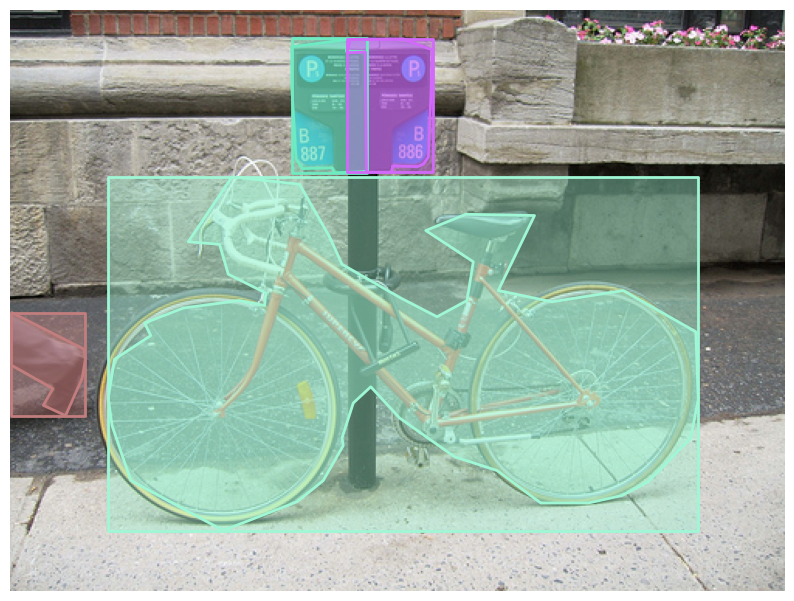

Image data: 


{'license': 1,
 'file_name': '000000370208.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000370208.jpg',
 'height': 375,
 'width': 500,
 'date_captured': '2013-11-14 23:16:53',
 'flickr_url': 'http://farm4.staticflickr.com/3114/2576404641_15ee5d5d25_z.jpg',
 'id': 370208}

In [ ]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt


def coco2pil(url):
    print(url)
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


catIds = coco.getCatIds(catNms=["person", "bicycle"])  # get category IDs
# person and bicycle
imgIds = coco.getImgIds(catIds=catIds)
img_list = coco.loadImgs(
    imgIds[12]
)  # http://images.cocodataset.org/val2017/000000370208.jpg
img = img_list[0]

# plot image
plt.figure(figsize=(10, 10))
pil_img = coco2pil(img["coco_url"])
plt.imshow(pil_img)

# plot boundy boxes
annIds = coco.getAnnIds(imgIds=img["id"])
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)
plt.axis("off")
plt.show()
print("Image data: ")
img

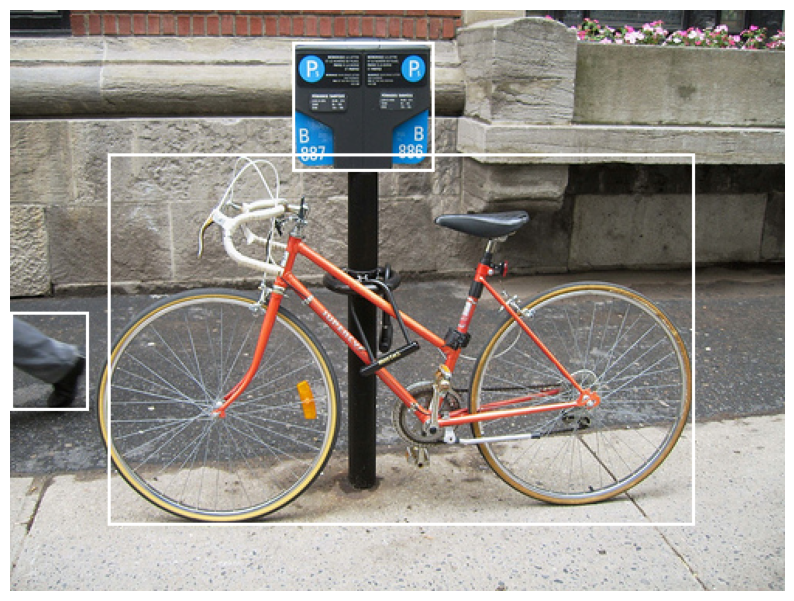

In [ ]:
import torchvision.transforms.functional as TF
from PIL import ImageDraw

# lets predict objects by resnet50
with torch.no_grad():
    tensor = TF.pil_to_tensor(pil_img) / 255  # Normalize
    output = fr_rcnn_model(tensor.unsqueeze(0))
    draw = ImageDraw.Draw(pil_img)

    # plot rectangles
    for i, bbox in enumerate(output[0]["boxes"]):
        if output[0]["scores"][i] > 0.5:
            draw.rectangle((tuple(bbox[:2].numpy()), tuple(bbox[2:].numpy())), width=2)

    plt.figure(figsize=(10, 10))
    plt.imshow(pil_img)
    plt.axis("off")
    plt.show()

#### Region proposal network (RPN)

Как устроена сеть, предсказывающая ROI?

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/out/roi_pooling.png" width="800">

Карта признаков имеет фиксированные и относительно небольшие пространственные размеры (например 20x15). Поэтому можно вернуться к идее скользящего окна, которая была отвергнута в самом начале из-за большого размера изображения.

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/rpn_base.png" width="700">

Для карты признаков размером 20x15 количество ROI получится равным 3000, что сравнимо с количеством предсказаний, производимых SelectiveSearch.

Далеко не всегда объект хорошо вписывается в квадрат:

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/out/rpn_aspect_ratio.png" width="900">

Поэтому для каждой точки на карте признаков (anchor) можно использовать окна нескольких форм:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/rpn_base_anchor.png" width="700">

<center><p><em>Source: <a href="https://aman.ai/cs231n/detection/">Detection and Segmentation</a></p> </em></center>

Это позволит минимизировать корректировку* и лучше предсказывать ROI  для вытянутых объектов.

\* *помним, что для каждого прямоугольника предсказываются 4 числа, обозначающих сдвиг его вершин относительно начального положения.*

Для каждого окна предсказываются два значения:

* вероятность того, что в ROI находится объект (одно число),
* смещения (4 числа).

Сама сеть при этом может быть очень простой:

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/out/simple_nn_predict_objectness_and_boundary_box.png" width="400">

#### Two stage detector



Если присмотреться к схеме, можно заметить, что на среднем и верхнем уровнях выполняются схожие операции.


Разница в том, что на последнем слое предсказывается класс объекта, а на промежуточном только вероятность его присутствия (objectness). 

Корректировки для вершин bounding box предсказываются и в обоих случаях.

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/two_stage_detector.png" width="750">

<center><p><em>Source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf">Detection and Segmentation</a></p> </em></center>

Можно сказать, что детектирование происходит в две стадии. 
Соответственно Faster RCNN == Two stage detector

### One Stage detector


Если сразу предсказывать класс, то можно избавиться от второй стадии.
В этом случае к списку классов нужно добавить еще один элемент, который заменит objectness либо будет предсказанием класса "фон".

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/out/one_stage_detector.png" width="800">

Детекторы, которые работают "за один проход", быстрее, но потенциально менее точные.



<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolo_ssd_retinanet.png" width="1000">

<center><p><em>Source: <a href="https://aman.ai/cs231n/detection/">Detection and Segmentation</a></p> </em></center>

Рассмотрим несколько моделей, построенных по этому принципу:
YOLO, SSD, RetinaNet

[Сравнение скорости моделей](https://pytorch.org/vision/stable/models.html#runtime-characteristics)

#### SSD: Single Shot MultiBox Detector

<img src ="http://edunet.kea.su/repo/EduNet-web_dependencies/L12/ssd_default_boxes.png" width="700">

<center><p><em>Source: <a href="https://ternak.github.io/cnn_detection.html">Object Detection With Convolution Neural Nets</a></p> </em></center>




* Кандидаты в ROI (default box) выбираются на нескольких слоях (4,7, 8, 9,11)
* Количество форм окон (default box) на картах признаков зависит от слоя: от 4 до 6

[SSD: Single Shot MultiBox Detector (Liu et al., 2015)](https://arxiv.org/abs/1512.02325)




<img src ="http://edunet.kea.su/repo/EduNet-web_dependencies/L12/single_shot_multibox_detector_scheme.png" width="1500">

<center><p><em>Source: <a href="https://arxiv.org/pdf/1512.02325.pdf">Single Shot MultiBox Detector</a></p> </em></center>

* В качестве backbone используется VGG-16, предобученная на ImageNet
* Добавлен класс для "background"


В общей сложности делается 8732 предсказаний, каждое содержит 4 + (N + 1) чисел. 

N — это количество классов без фона,
4 — смещения.


[Подробнее.](https://towardsdatascience.com/review-ssd-single-shot-detector-object-detection-851a94607d11)

### Loss для детектора

Как подсчитать loss для детектора. Loss должн включать в себя две части: ошибку локализации и ошибку классификации.

И для SSD loss function так и выглядит:

$$L(x,c,l,g) = \frac{1}{N}(L_{conf}(x,c) + \alpha L_{loc}(x,l,g))$$


Однако если мы будем считать ошибку локализации для всех default box, то она никогда не будет нулевой.
Default box очень плотно перекрывает все изображение и в большинство из них объект не попадет, особенно если объект один и небольшой.

<img src ="http://edunet.kea.su/repo/EduNet-web_dependencies/L12/default_boxes.png" width="700">

<center><p><em>Source: <a href="https://ternak.github.io/cnn_detection.html">Object Detection With Convolution Neural Nets</a></p> </em></center>

Поэтому часть default box при подсчете loss игнорируются. Используются только те, у которых  большая площадь пересечения с одним из истинным bounding box больше порога (IoU > 0.5)



$$L(x,l,g)_{loc} = \sum_{i \in Pos}^{N} x_{i,j}^{k}smooth_{L1}(l_i, g_j)$$


Здесь:

$l$ — финальные координаты предсказанного bounding box с учетом смещений,

$g$ — координаты истинного bounding box,

$M$ — количество истинных (ground true) bounding box-ов,

$Pos$ — список отобранных default box пересекающихся с истинными,

$x_{i,j}^{k} = \{1,0\}$ — индикатор того, что комбинация default и box валидна.



> i — индекс default box,
> j — индекс истинного (ground true) bounding box,
> p — номер класса, к которому относится ground true bounding box (не степень).

$smooth_{L1}$ — [Комбинация L1 и L2](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html) 

Компонент, отвечающий за классификацию:

$$L(x,с)_{conf} = -\sum_{i \in Pos} x_{i,j}^{k} log(softmax(c_{i}^{p})) -\sum_{i \in Neg} log(softmax(c_{i}^{0}))$$

$c_{i}^{p}$ — вектор score для i-того default box, p — номер истинного класса, соответствующего bounding box из разметки

$Pos$ — список отобранных default box, не пересекающихся с истинными (IoU < treshold)






\* *Формулы для loss function осознанно упрощены. Например, мы опустили расчет L1 для смещений, что является технической деталью.*






### FocalLoss

Следующий заслуживающий внимания one-stage детектор это Retina Net — [Focal Loss for Dense Object Detection (Lin et al., 2017)](https://arxiv.org/abs/1708.02002)

Собственно, авторы придумали новую функцию потерь (Focal Loss) и опубликовали модель, чтобы продемонстрировать её эффективность.

Чтобы понять, какую проблему решает Focal Loss, давайте посмотрим на второй компонент Loss классификации для SSD:

$$L_{conf} =  \ ...\  -\sum_{i \in Neg} log(softmax(c_{i}^{0}))$$

Это кросс-энтропия для bounding boxes, содержащих фон. Тут нет ошибки: когда модель обучится правильно предсказывать класс фона (background), каждая из этих компонент будет небольшой.

Проблема в том, что таких компонент очень много. Детектор предсказывает несколько тысяч, или десятков тысяч bounding boxes. Подавляющая часть из них приходится на фон. Cумма большого количества этих небольших потерь (loss) становится заметным числом и мешает учиться классифицировать реальные объекты.

Как решается эта проблема в Focal Loss?

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/focal_loss_vs_ce.png" width="700"></center>

<center><em>Source: <a href="https://arxiv.org/abs/1708.02002">Focal Loss for Dense Object Detection (Lin et al., 2018)</a></em></center>





Фактически loss для уверенно классифицированных объектов дополнительно занижается. Это похоже на взвешивание при дисбалансе классов.

Достигается этот эффект путем домножения на коэффициент: $ (1-p_{t})^\gamma$

Здесь:

$ p_{t} $ — вероятность истинного класса,

$ \gamma $ — число большее 1 и являющееся гиперпараметром.


Пока модель ошибается, $p_{t}$ — мало, и значение выражения в скобках соответственно близко к 1. 

Когда модель обучилась, значение $p_{t}$ становится близким к 1, а разность в скобках становится маленьким числом, которое возводится в степень $ \gamma $ > 1. Таким образом, домножение на это небольшое число нивелирует вклад верно классифицированных объектов.

Это позволяет модели сосредоточиться на изучении сложных объектов (hard example )

[Подробнее про FocalLoss](https://github.com/Gan4x4/ml_snippets/blob/main/FocalLoss.ipynb)


### Нard Example Mining

При обучении модели, мы можем обнаружить, что средняя ошибка на всех данных достаточно маленькая, однако ошибка на редких нетипичных данных довольно высока. При этом нетипичные данные необязательно являются выбросами.

Разберемся, почему так происходит.
К примеру, рассмотрим задачу обнаружения автомобилей на потоках данных с камер наружного видеонаблюдения. Если в обучающем наборе большая часть данных — снимки, сделанные днём, то качество работы модели ночью будет низким. В данном случае, "нетипичными" данными будут ночные снимки. Но, на самом-то деле, "нетипичных" случаев может быть довольно много, и некоторые из них могут происходить даже днём. Например: 
* изменение погоды (изменение яркости, резкости, помехи на изображении),
* смена сезона (снег либо листья могут покрыть дорогу — изменение фона),
* машины с экзотическими узорами на кузове.

Довольно простым и эффективным решением проблемы является сбор "сложных" случаев (**hard example mining**) и дообучение модели на них. При этом, поскольку модель уже довольно хорошо работает на большей части данных, можно дополнительно удалить часть данных из обучающей выборки — таким образом мы сосредотачиваем модель на обучении на сложных примерах.

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/out/hard_example_mining.png" width="1000">

#### Online hard example mining

В некоторых случаях hard exapmle mining можно выполнять прямо во время формирования батча, "налету". В таких случаях говорят про **online hard example mining**.

Один из вариантов может быть реализован в two-stage детекторах.
Напоминаю: первая часть детектора отвечает за обнаружение regions of interest (RoI), затем выполняется (как правило, сравнительно вычислительно дешёвая) классификация. Одним из вариантов реализации идеи может быть выполнение forward pass классификатора по всем предложенным RoI и затем формирование батча, в котором будет выделено определённое количество "мест" под RoI, предсказания на которых выполняются наихудшим образом.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/online_hard_example_mining.png" width="700"></center>

<center><p><em>Source: <a href="https://sklin93.github.io/hog.html"> HoG Face Detection with a Sliding Window </a></p> </em></center>



### Feature pyramid network

Вторым полезным нововведением  в RetinaNet стало использование пирамиды признаков.

[Feature Pyramid Networks for Object Detection (Tsung-Yi Lin et al., 2017)](https://arxiv.org/abs/1612.03144)

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/retinanet_use_outputs_fpn.png" width="900">

<center><p><em>Source: <a href="https://link.springer.com/article/10.1007/s11042-022-13153-y?error=cookies_not_supported&code=d283d48a-d725-4d7e-a568-7955a14a0550">Tools, techniques, datasets and application areas for object detection in an image: a review</a></p> </em></center>


RetinaNet использует выходы FPN для предсказаний и класса, и bbox. Мы уже обсуждали пирамиды признаков применительно к сетям для сегментации, в частности, FCN. 

На каждом сверточном слое извлекаются карты признаков. 

Их пространственное разрешение постепенно уменьшается, а глубина (количество каналов) увеличивается.


Но первые слои содержат мало семантической информации (только низкоуровневые признаки).  А карты признаков с глубоких слоев имеют низкое пространственное разрешение, что не позволяет качественно определить границы объектов.





<img src ="https://edunet.kea.su/repo/EduNet-content/L12/out/semantic_information.png" width="650">

<left><p><em>Source: <a href="https://arxiv.org/pdf/1612.03144.pdf">Feature Pyramid Networks for Object Detection</a></p> </em></center>

Так же, как и в случае с сегментацией, точность повышается, если делать предсказания на картах, содержащих признаки для разных масштабов.


При этом можно получать карты с большим пространственным разрешением не просто сохраняя их в памяти, а еще и прибавляя к ним значения признаков с более глубоких слоев, предварительно интерполировав их (Upsample).

Идея состоит в том, чтобы делать предсказание с учетом семантической информации, полученной на более глубоких слоях. Здесь признаки   суммируются, а не конкатенируются.

Затем к новым картам признаков может применяться дополнительная свертка.

На выходе получаем карты признаков P2—P5, на которых уже предсказываются bounding boxes.

<img src ="https://edunet.kea.su/repo/EduNet-content/L12/out/resnet_prediction_head_scheme.png" width="850">

В случае 2-stage детектора (RCNN) новые карты признаков подаются на вход RPN.

<img src ="http://edunet.kea.su/repo/EduNet-web_dependencies/L12/features_from_blackbone.jpeg" width="1100">

<center><p><em>Source: <a href="https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c">Understanding Feature Pyramid Networks for object detection (FPN)</a></p> </em></center>

А признаки для предсказаний используются из backbone.

Дополнительно: [Блог-пост про FPN](https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c)

### YOLO

* [You Only Look Once: Unified, Real-Time Object Detection (Redmon et. al., 2015)](https://arxiv.org/abs/1506.02640) 
* [YOLO9000: Better, Faster, Stronger (Redmon et. al., 2015)](https://arxiv.org/abs/1612.08242)
* [YOLOv3: An Incremental Improvement (Redmon et. al., 2018)](https://arxiv.org/abs/1804.02767)
* [YOLOv4: Optimal Speed and Accuracy of Object Detection (Bochkovskiy et al., 2020)](https://arxiv.org/abs/2004.10934)
* [YOLOv5 (Glenn Jocher Ultralytics,  June 2020)](https://github.com/ultralytics/yolov5)
* [YOLOX: Exceeding YOLO Series in 2021 (Ge et al., June 2021)](https://arxiv.org/abs/2107.08430)

* [YOLOv7: Trainable bag-of-freebies sets new state-of-the-art for real-time object detectors(Chien-Yao Wang et. al. July 2022)](https://arxiv.org/abs/2207.02696)

*  [YOLOv6: A Single-Stage Object Detection Framework for Industrial Applications(Chuyi Li et. al., Sept 2022)](https://arxiv.org/abs/2209.02976)

*  	[YOLOv8,	Ultralytics, Dec. 2022](
https://github.com/ultralytics/ultralytics)
[(documentation !)](https://docs.ultralytics.com/)

* [YOLO6v3	YOLOv6 v3.0: A Full-Scale Reloading Chuyi Li et. al., Dec. 2023](https://arxiv.org/abs/2301.05586)


<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolov6_performance.png" width="1000">

<center><p><em>Source: <a href="https://arxiv.org/abs/2301.05586">YOLOv6 v3.0: A Full-Scale Reloading
</a></p> </em></center>


Первая версия YOLO вышла в том же году что и SSD. На тот момент детектор несколько проигрывал SSD в точности.

Однако благодаря усилиям Joseph Redmon проект поддерживался и развивался в течение нескольких лет.

 3-я версия детектора оказалась настолько удачной, что даже в 2021 можно было прочесть:  "YOLOv3, one of the most widely used detectors in industry" [2021](https://arxiv.org/abs/2107.08430)

Последующие версии создавались разными авторами. Полагаю что правильно считать их разными форками YOLOv3 а не новыми версиями. Даже нумерация условна, например статья про v7 датируется более ранней датой чем v6.

В прикладных задачах я бы рекомендовал использовать YOLOv8 так как авторы выложили на свой сайт [документацию](https://docs.ultralytics.com/), а точность при скорости порядка 100 fps у всех современных моделей почти одинакова.

В настоящий момент можно сказать, что YOLO — это оптимальный детектор по соотношению качества распознавания к скорости.

Далее мы выборочно рассмотрим некоторые версии что бы разобраться какие именно техники позволили так существенно улучшить качество и скорость детектирования.





#### YOLOv3

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolov3.png" width="1200">

<center><p><em>Source: <a href="https://towardsdatascience.com/yolo-v3-object-detection-53fb7d3bfe6b#:~:text=YOLO%20v2%20used%20a%20custom,more%20layers%20for%20object%20detection.&text=First%2C%20YOLO%20v3%20uses%20a,layer%20network%20trained%20on%20Imagenet.">What’s new in YOLO v3?</a></p> </em></center>


В качестве backbone используется оригинальная сверточная сеть DarkNet53, задействующая слои Batch Norm и Skip connection. Но есть реализации с ResNet в качестве backbone.

Детектор использует большинство техник, которые мы обсудили:

* Default boxes извлекаются на трех слоях различной глубины. Для каждой ячейки  предсказывается З окна
* FPN: признаки конкатенируются, а не складываются
* Resolution augmentation: При обучении разрешение входных изображений менялось от 384x384 до 672x672
* В качестве loss function для классификации используется бинарная кросс-энтропия, позволяющая предсказывать несколько объектов в одном bounding box. Что позволяет использовать детектор с multilabel датасетами, где один объект может иметь несколько меток (person & woman)
* Предсказывается дополнительный параметр objectness score. Он не связан с классификацией. Его задача — предсказать, насколько вероятно, что в предсказанном default boх действительно есть объект и он будет учитываться при подсчете loss

##### Формат предсказаний

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolov3_prediction.png" width="400">

<left><p><em>Source: <a href="https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/">How to implement a YOLO (v3) object detector from scratch in PyTorch</a></p> </em></center>

Соответственно, для каждого anchor box предсказывается вот такой вектор значений:

* смещения;
* objectness — вероятность наличия объекта;
* scores — уверенность того, что bbox содержит объект определенного класса. Для моделей тренированных на СOCO классов 80.

Для 80-ти классов получается 85 значений на один default box.

#### <font color="orange"> Предсказание смещений</font>

Вот так преобразуются предсказания YOLOv3 для получения финальных координат bounding box

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolov3_coordinates_prediction.png" width="500">

<left><p><em>Source: <a href="https://arxiv.org/pdf/1612.08242.pdf">YOLO9000:
Better, Faster, Stronger</a></p> </em></center>




$c_{x} , c_{y}$ — это координаты верхнего левого угла default box
$p_{w} , p_{h}$ — это ширина и высота default box
$t_{x} , t_{y}$ — предсказанные смещения  для центра
$t_{w} , t_{h}$ — предсказанные корректировки  для ширины и высоты

$b_{x} , b_{y}, b_{w}, b_{h}$ — координаты центра, ширина и высота финального предсказанного bouning box. Значения в процентах от ширины и длины исходного изображения

$\sigma(x) $ — сигмоида

$e$ — число Эйлера

сторона каждой клетки равна 1-це так как это просто порядковый номер элемента в строке и столбце.

##### <font color="orange">Почему не предсказывть абсолютные значения?</font>



Как видно по схеме не предсказываются абсолютные значения смещений. Почему вместо того что бы в понятной регрессионной задаче не предсказать 4 числа предсказываются  коеффициенты, с которыми затем происходят неочевидные преобразования?

Что бы ответить на этот вопрос вспомним про нормализацию данных. Мы нормализуем входные данные, и центрируем их вокруг нуля.

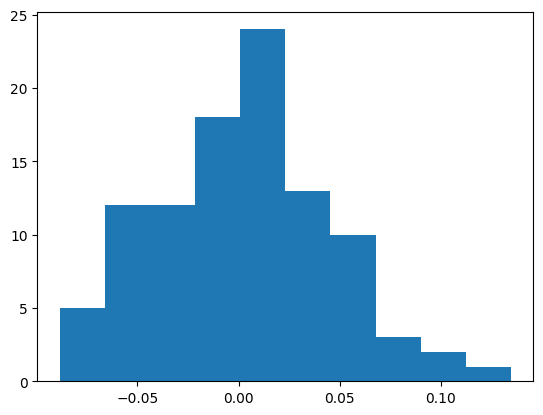

Mean: 0.00 Variance: 1.00


In [ ]:
import torch
import matplotlib.pyplot as plt

x = torch.randn((512, 100))  # Fake normalized data
plt.hist(x.mean(dim=0), bins=10)
plt.show()
print(f"Mean: {x.mean().item():.2f} Variance: {x.var().item():.2f}")

 Кроме того мы определенным образом инициализируем веса и добавляем слои ализации что бы распределение входов очередного слоя (они же выходы предидущего) более-менее сохранялось.  

In [ ]:
from torch import nn

net = nn.Sequential(
    nn.Linear(100, 50),  # weights randomly sampled from some random distribution
    nn.ReLU(),
    nn.BatchNorm1d(50),
    nn.Linear(50, 1),
)

Веса инициализированны равномерно расперделены вокруг нуля:

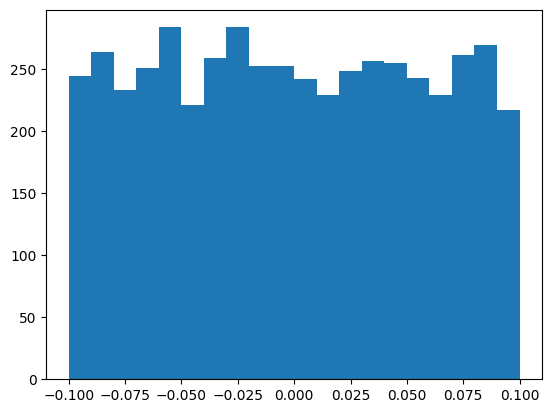

-0.0007243642


In [ ]:
weights = net[0].weight.data.numpy()
plt.hist(weights.flatten(), bins=20)
plt.show()
print(weights.mean())

И на выходе последнего слоя будет та же ситуация: необученная сеть будет чаще всего предсказывать около нулевые значения:

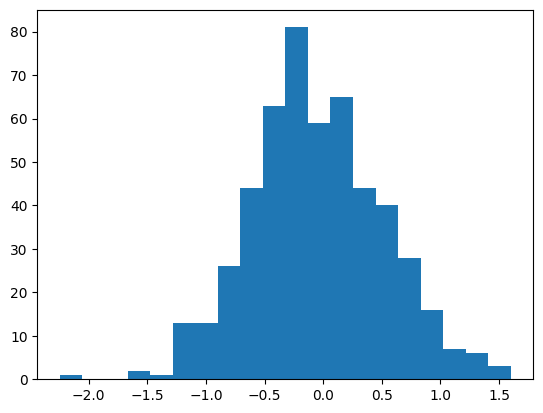

Mean: -0.05 Variance: 0.32


In [ ]:
out = net(x)
plt.hist(out.detach().numpy(), bins=20)
plt.show()
print(f"Mean: {out.mean().item():.2f} Variance: {out.var().item():.2f}")

Если мы будем пытаться предсказывать большие по модулю значения, например абсолютные координаты:

In [ ]:
targets = torch.randint(0, 224, (512, 1))  # fake coordinate in range [0 .. 255]
print(targets[:10].flatten())

tensor([213, 167,  19, 122, 137,  72,   5,  50, 114,  48])


То получим огромную ошибку, которая повлечет большое обновление весов приведет к нестабильному обучению, большим абсолютным значениям весов и.т.п.

In [ ]:
criterion = nn.MSELoss()
loss = criterion(out, targets)
print("Loss", loss.item())

Loss 16324.80078125


Если мы стандартизуем координаты(targets)

In [ ]:
mean = targets.float().mean()
std = targets.float().std()

transformed_targets = (targets - mean) / std

print(transformed_targets.flatten()[:10])

tensor([ 1.6462,  0.8960, -1.5177,  0.1621,  0.4067, -0.6533, -1.7460, -1.0121,
         0.0316, -1.0447])


То получим ошибку на 4 порядка меньше:

In [ ]:
loss = criterion(out, transformed_targets)
print("Loss", loss.item())

Loss 1.3649822473526


Фактически теперь мы предсказываем смещение от среднего значения. Что бы его затем использовать надо его денормализовать

In [ ]:
real_out = out * std + mean
print(real_out.int().flatten()[:10])  # values like a coords

tensor([ 95, 124,  20,  84, 174,  59, 114, 173, 107, 203], dtype=torch.int32)


Иногда такую постобработку удобно включить в модель, что бы она учитывалась при подсчете loss. 

**Центр**

В случае когда смещение не нужно, сеть предсказывает нулевые значения для $t_{x} и t_{y}$ 

$\sigma(0) = 0.5$





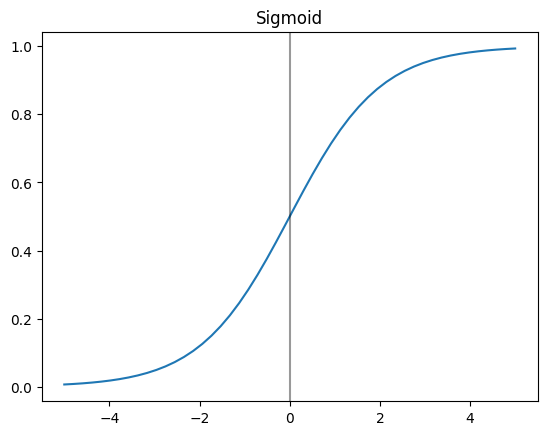

In [ ]:
# plot sigmoid function
import numpy as np

x = np.linspace(-5, 5)
y = 1 / (1 + np.exp(-x))
plt.plot(x, y)
plt.axvline(0, color="black", alpha=0.4)
plt.title("Sigmoid")
plt.show()

Сответственно центр предсказанного bbox окажется в центре клетки и совпадет с центром default box

Если смешение t большОе положительное to $\sigma(t)$ будет близко к +1 и центр сместиться к правой границе ячейки. Однако никода не выйдет за ее пределы т.к. $\sigma(t) < 1$

Аналогично для отрицательных значений. 

Это ровно то что нам нужно, так как за пердсказания bbox объектов, центры которых лежат в других ячейках должны отвечать default box соответствующих ячеек.



*Щирина и высота *

Корректировоку для ширины и высоты нет смысла ограничивать единицей, так как объект может занимать несколько ячеек и даже выходить за границу изображения.

Здесь ширина и высота  default box ($p_{w} , p_{h}$) масштабируются путем умножения на $e^t$ 



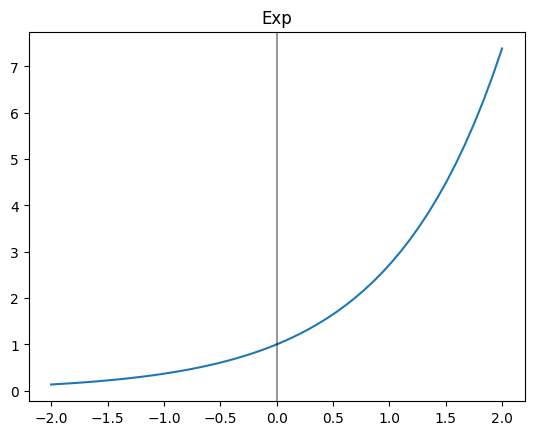

In [ ]:
# Plot exponent
x = np.linspace(-2, 2)
y = np.exp(x)
plt.plot(x, y)
plt.axvline(0, color="black", alpha=0.4)
plt.title("Exp")
plt.show()

При $t~= 0$ когда сеть необучена или корректировка не нужна $e^0 ~=1$ и $b =p*e^t ~= p$

Чем заметном отклонеии t от нуля ширина с высотой будут либо стремительно расти (при t>>0) либо стремительно уменьшаться (t<<0)

P.S. Этот прием часто используется для предсказания сетью значений имеющих большой разброс.

#### YOLOv4

YOLOv3 на момент выхода стал одним из самых быстрых детекторов и последней версией за авторством Джозефа Редмона.

YOLOv4 — это детище других авторов. Модель не стала быстрее, но стала намного более точной.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolov4.jpeg" width="700"></center>

<center><p><em>Source: <a href="https://medium.com/visionwizard/yolov4-version-3-proposed-workflow-e4fa175b902"> YOLOv4 — Version 3: Proposed Workflow</a></p> </em></center>

Что же добавили авторы:

1. Поменялся Backbone:
* Увеличилось количество слоев,
* Добавился SPP block,
* Добавились Dense блоки (дополнительные skip connection как в [DenseNet](https://arxiv.org/abs/1608.06993))
* Появились PAN блоки (Path Aggregation Network Module)




##### Path Aggregation Network Module(PAN)




<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/pan.png" width="600"></center>

<center><p>
[Path Aggregation Network for Instance Segmentation](https://openaccess.thecvf.com/content_cvpr_2018/papers/Liu_Path_Aggregation_Network_CVPR_2018_paper.pdf)
</center></p>


а) Строится пирамида признаков, при этом некоторые карты признаков дополняются  признакими с более ранних слоев (красный пунктир)

b) Затем на основе последнего слоя FPN строится еще одна, (Bottom-up) и опять новые  карты признаков дополняются признакими полученными на первом уровне  (зеленый пунктир)

2. *Поменялся [процесс обучения](https://blog.roboflow.com/yolov4-data-augmentation/)*. В частности использовались такие техники аугментации как :


##### Mosaic augmentation

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/mosaic_augmentation.jpg" width="900"></center>

<center><p><em>Source: <a href="https://medium.com/visionwizard/yolov4-version-3-proposed-workflow-e4fa175b902"> YOLOv4 — Version 3: Proposed Workflow </a></p></em></center>

Изображение, которое подается на вход сети, склеивается из нескольких (4) фрагментов разных изображений. При этом статистика для Batch norm считается по 4-м полным изображениям.
Такая стратегия позволяет уменьшить размер batch, что важно при работе с изображениями, имеющими большое разрешение.

##### Self-Adversarial Training (SAT)

Это [Adversarial attack](https://en.wikipedia.org/wiki/Adversarial_machine_learning) непосредственно в процессе обучения. Для каждого batch выполняется 2 forward и 2 backward прохода:
*  Выполняется прямой проход и подсчитывается loss
*  После первого прохода обновляются изображения а не веса сети
*  Далее сеть учится на измененных изображениях





#### YOLOv5


<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolov5.png" width="900"></center>


Статья не публиковалась.
Точность сравнима  с v4, но модель определенно хорошо упакована и была доступна на [torch.hub](https://pytorch.org/hub/ultralytics_yolov5/)





<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolo5_ver.png" width="700"></center>

 В репозитории содержиться несколько предобученных моделей. Чем больше параметров у модели тем она точнее и одновременно медленне.


#### <font color="orange">YOLOX</font>


<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolox_speed.png" width="500"></center>

<center><p><em>Source: <a href="https://arxiv.org/pdf/2107.08430.pdf"> YOLOX: Exceeding YOLO Series in 2021</a></p> </em></center>


Авторы использовали в качестве baseline модели YOLOv3, и, убедившись на ней в эффективности усовершенствований, применили некоторые из них к YOLOv4 и YOLOv5.

Далее рассмотрим список нововведений.

##### Decoupled head

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolox_decoupled_head.png" width="700">

<center><p><em>Source: <a href="https://arxiv.org/pdf/2107.08430.pdf">YOLOX: Exceeding YOLO Series in 2021
</a></p> </em></center>

Так же, как в RetinaNet, для регрессии и классификации используются различные головы (подсети).

##### Anchor-free

Все детекторы, которые рассматривались ранее, использовали несколько предопределенных default box (anchor) для каждой точки на карте признаков.
Количество и размер этих якорных окон являются гиперпараметрами модели.

В 2019 г вышла статья [FCOS: Fully Convolutional One-Stage](https://towardsdatascience.com/forget-the-hassles-of-anchor-boxes-with-fcos-fully-convolutional-one-stage-object-detection-fc0e25622e1c), где авторы отказываются от такого подхода. Для каждой точки на карте признаков сразу предсказывают один bounding box.

Если пиксель, соответствующий центру предсказанного bounding box, попадает в истинный (ground true) bounding box, то он используется при подсчете loss.

Это подход был применен и в YOLOX.

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolox_techniques.png" width="1000">

<center><p><em>Source: <a href="https://arxiv.org/pdf/2107.08430.pdf">YOLOX: Exceeding YOLO Series in 2021
</a></p> </em></center>




* and advanced label assigning strategy (SimOTA)
* MultiPositives
* OTA/SimOTA

#### YOLOv6v3


 Судя по результатам опубликованным в статье, это модель самая точная из семейства YOLO на начало 2023г.

В статье описанны следующие модификации архитектуры и техники обучения:

 

Усовершениствована PAN подсеть ("шея")

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolov6_neck.png" width="1000"></center>


<center><p><em>Source: <a href="https://arxiv.org/abs/2301.05586">YOLOv6 v3.0: A Full-Scale Reloading
</a></p> </em></center>




 ##### Anchor-Aided Training

 <center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/L12/yolov6_head.png" width="600"></center>


<center><p><em>Source: <a href="https://arxiv.org/abs/2301.05586">YOLOv6 v3.0: A Full-Scale Reloading
</a></p> </em></center>

 В режиме вывода детектор работает в anchor-free режиме. То есть предсказывает только один boundong box на элемент карты признаков.

 Но при обучении использовался дополнительный (auxilliary) anchor-based блок, выходы которого же учитывались при подсчете loss. В режиме вывода он не задействуется и соответственно не оказывает влияние на скорость.

##### Self-distillation

При обучении легких моделей использовались тяжелые. 

При дистилляции к loss полученному при помощи разметки ($L_{det}$) добавляется 2й компонент, который сравнивает выходы большой (teacher) и малой (student) моделей. 

$ L = L_{det} + \alpha L_{KD}$ 

Сравнение выходов (распределений) можно провести при помощи KL дивергенции. 

$L_{KD} = KL(p_t^{cls} || p_s^{cls} ) + KL(p_t^{reg}||p_s^{reg})$

$p_t^{cls}$ - предсказания вероятностей классов учителем

$p_s^{cls}$ - предсказания вероятностей классов обучаемой модели (student)

$p_t^{reg}$ - предсказания смещений учителем

$p_s^{reg}$ - предсказания смещений учеником


Подробнее про такой подход можно прочесть в статье: [Generalized Focal Loss: Learning Qualified and Distributed Bounding Boxes for Dense Object Detection](https://paperswithcode.com/paper/generalized-focal-loss-learning-qualified-and)


В случае с YOLOv6v3 при дистиляции для второй компоненты loss ($L_{KL}$) использовал дополнительный выход, который не задействуется в режиме вывода.



К сожалению [документация к API](https://yolov6-docs.readthedocs.io/zh_CN/latest/) модели выложена только на китайском языке.

#### YOLOv8

По этой модели не публиковалась статья, зато есть [документация](https://docs.ultralytics.com/quickstart/)

Попробуем попробуем запустить ее.

In [ ]:
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.5/586.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 15.3 MB/s eta 0:00:00


Инстанцируем модель по названию. Полный [список предобученных моделей](https://github.com/ultralytics/ultralytics#models) .

In [ ]:
from ultralytics import YOLO

yolo8 = YOLO("yolov8n.pt")

100%|██████████| 6.23M/6.23M [00:00<00:00, 75.8MB/s]


Скачаем тестовое изображение

In [ ]:
! wget https://edunet.kea.su/repo/EduNet-web_dependencies/L01/gentelmens.jpg

--2023-05-18 10:06:11--  https://edunet.kea.su/repo/EduNet-web_dependencies/L01/gentelmens.jpg
Resolving edunet.kea.su (edunet.kea.su)... 89.175.15.242
Connecting to edunet.kea.su (edunet.kea.su)|89.175.15.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77148 (75K) [image/jpeg]
Saving to: ‘gentelmens.jpg’

gentelmens.jpg      100%[===================>]  75.34K   209KB/s    in 0.4s    

2023-05-18 10:06:13 (209 KB/s) - ‘gentelmens.jpg’ saved [77148/77148]



Загрузим и детектируем на нем объекты.

Из коробки работает с изображениями в разных форматах и даже url, автоматически меняет размер входного изображения, возвращает объект с результатами...

In [ ]:
from PIL import Image

# pil_img = Image.open("gentelmens.jpg")
results = yolo8("gentelmens.jpg")


image 1/1 /content/gentelmens.jpg: 448x640 1 person, 1 tie, 2 vases, 169.7ms
Speed: 15.2ms preprocess, 169.7ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)


В качестве результата возвращается список объектов которые содержат информацию полную информацию о детектировании.



In [ ]:
print(len(results))  # contains detections for one image

1


У него есть методы для получения списка координат предсказанных bounding box после NMS

In [ ]:
# https://docs.ultralytics.com/reference/results/
print(results[0].boxes.data)  # x1,y2,x2,y2,conf,class_num

tensor([[3.4140e+02, 5.6345e+01, 4.7475e+02, 4.7698e+02, 8.1170e-01, 0.0000e+00],
        [1.4253e+02, 3.2648e+02, 2.1434e+02, 4.0533e+02, 4.8517e-01, 7.5000e+01],
        [3.7530e+02, 1.6042e+02, 3.9831e+02, 2.6112e+02, 3.1243e-01, 2.7000e+01],
        [2.1163e+02, 3.2848e+02, 2.7738e+02, 4.0293e+02, 2.7357e-01, 7.5000e+01]])


Может даже создать картинку с нарисоваными bounding box. 

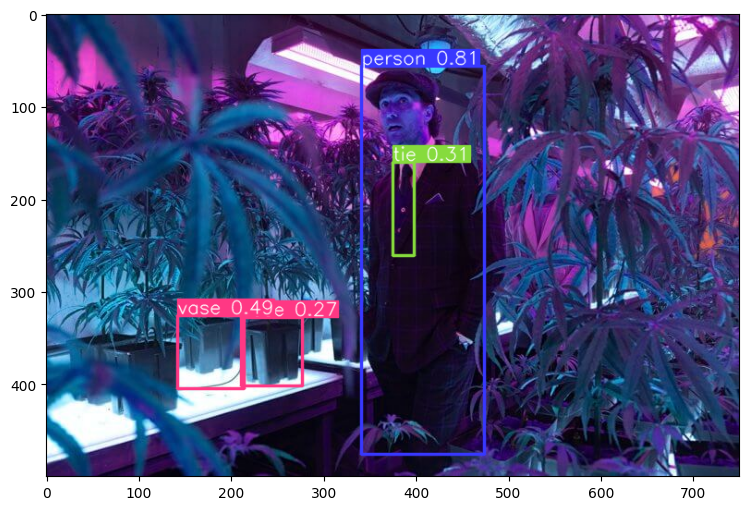

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
pil_with_bbox = results[0].plot()
plt.imshow(pil_with_bbox)  # BGR?
plt.show()

Похоже объект results хранит картинку в BGR формате, переведем в RGB

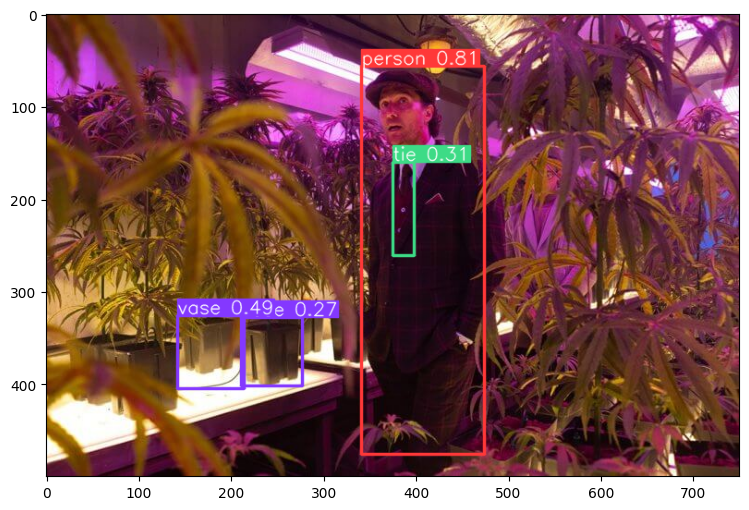

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(pil_with_bbox[..., ::-1])  # BGR->RGB
plt.show()